In [1]:
from matplotlib import pyplot as plt
import openmc

# OpenMC Geometry: The Basics

Learning goals:

  - Understand how to define basic surfaces and composite surfaces
  - Understand the meaning of surface halfspaces and surface senses
  - Create cells from combinations of surfaces

# OpenMC Geometry

 - All spaces of a model up to a boundary condition must be defined
 - Geometries are composted of:
   - `Surface`'s (used to create regions for cells)
   - `Cell`'s (associated with a region)
   - `Universe`'s (collections of cells)
 - All of these constructs have corresponding Python objects in the `openmc` Python module.

# Surfaces

  - A full list of the surface types supported in OpenMC can be found [here](https://docs.openmc.org/en/stable/usersguide/geometry.html#id2)
  

In [2]:
cylinder_surface = openmc.ZCylinder(r=5)
print(cylinder_surface)
x_plane = openmc.XPlane(x0=0)
print(x_plane)
y_plane = openmc.YPlane(y0=0)
print(y_plane)

Surface
	ID                 =	1
	Name               =	
	Type               =	z-cylinder
	Boundary           =	transmission
	Coefficients       
x0                  =	0.0
y0                  =	0.0
r                   =	5

Surface
	ID                 =	2
	Name               =	
	Type               =	x-plane
	Boundary           =	transmission
	Coefficients       
x0                  =	0

Surface
	ID                 =	3
	Name               =	
	Type               =	y-plane
	Boundary           =	transmission
	Coefficients       
y0                  =	0



  - `Surface`'s are automatically assigned an ID upon creation.
  - `Surface`'s can be assigned name for human-readable recognition.
  - Boundary conditions are assigned to surfaces to define the problem boundary.
      - Transmission (default)
      - Vacuum
      - Reflective
      - Periodic
      - White

In [3]:
help(openmc.Surface)

Help on class Surface in module openmc.surface:

class Surface(openmc.mixin.IDManagerMixin, abc.ABC)
 |  Surface(surface_id=None, boundary_type='transmission', albedo=1.0, name='')
 |  
 |  An implicit surface with an associated boundary condition.
 |  
 |  An implicit surface is defined as the set of zeros of a function of the
 |  three Cartesian coordinates. Surfaces in OpenMC are limited to a set of
 |  algebraic surfaces, i.e., surfaces that are polynomial in x, y, and z.
 |  
 |  Parameters
 |  ----------
 |  surface_id : int, optional
 |      Unique identifier for the surface. If not specified, an identifier will
 |      automatically be assigned.
 |  boundary_type : {'transmission, 'vacuum', 'reflective', 'periodic', 'white'}, optional
 |      Boundary condition that defines the behavior for particles hitting the
 |      surface. Defaults to transmissive boundary condition where particles
 |      freely pass through the surface. Note that periodic boundary conditions
 |      can

# Regions

  - Regions are defined by the "halfspaces" or "senses" of surfaces and are defined using the `-` or `+` operators on an OpenMC surface object.
  - `+`: For an open surface (e.g. a plane), all space on the positive side of the surface. For closed surfaces (e.g. a cylinder), the exterior of the surface. 
  - `-`: For a closed surface, all space on the positive side of the surface. For closed surfaces, the interior of the surface. 
  
  - These halfspaces can be combined together using the following Boolean operators:
      - Intersection: `&` (logical and)
      - Union: `|` (logical or)
      - Complement: `~` (inverse)

In [4]:
halfspace = -cylinder_surface
print(halfspace)

region = -cylinder_surface & +x_plane
print(region)

-1
(-1 2)


The bounding box of simple regions can be determined with the `Region.bounding_box` property.

In [5]:
region.bounding_box

BoundingBox(lower_left=(0.0, -5.0, -inf), upper_right=(5.0, 5.0, inf))

# Cells


In OpenMC, cells tie a material definition and region of space together. Materials will be discussed in more detail later on. For now a simple material will be defined.

Similar to surfaces, `Cell`'s are automatically assigned an ID if one is not provided and can be assigned a name.

In [19]:
water = openmc.Material()
water.set_density('g/cc', 1.0)
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)

water_cell = openmc.Cell(fill=water, region=region)
print(water_cell)

Cell
	ID             =	2
	Name           =	
	Fill           =	Material 2
	Region         =	(-1 2)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None



# Universes


Universes are, simply put, a collection of cells. This collection of cells can be used instead of a material to fill CSG cells, allowing the geometry unit defined by a universe to appear multiple times in the geometry without repeating the universe's cell definitions.

In the simplest case, a model will contain only one universe.

The top-level universe in this nesting structure (or hierarchy) is referred to as the "root universe".


In [8]:
universe = openmc.Universe()
universe.add_cell(water_cell)

## Region Examples

The content of a universe can be plotted using the `Universe.plot` method in our notebooks.


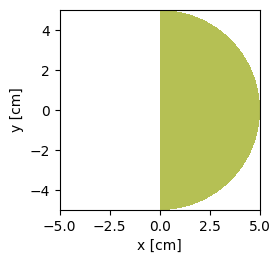

In [9]:
universe.plot(origin=(0, 0, 0), width=(10, 10))
plt.show()

A `Cell`'s region can be updated by setting the `Cell.region` directly like so:

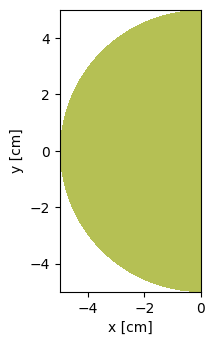

In [10]:
water_cell.region = -cylinder_surface & -x_plane
universe.plot()
plt.show()

Region operators can be chained like so

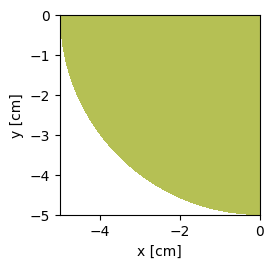

In [11]:
water_cell.region = -cylinder_surface & -x_plane & -y_plane
universe.plot()
plt.show()

Finally, parenthesis can be used in expressions. Here, they are used to define a region that is the upper-most and lower-most quadrants of the X-Y plane using the union operator

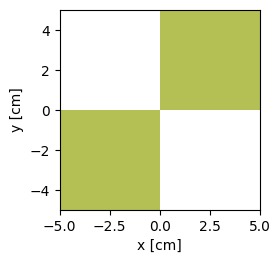

In [12]:
water_cell.region = (-x_plane & -y_plane) | (+x_plane & +y_plane)

universe.plot()
plt.show()

And with additional parenthesis, we can bound these quadrants using the cylinder surface

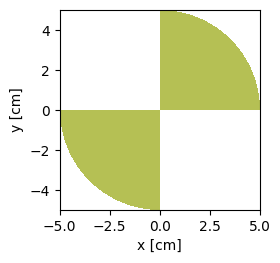

In [13]:
water_cell.region = -cylinder_surface & ((-x_plane & -y_plane) | (+x_plane & +y_plane))
universe.plot()
plt.show()

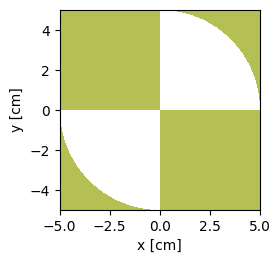

In [14]:
water_cell.region = ~water_cell.region
universe.plot()
plt.show()

# Composite Surfaces

Similar in nature to the macrobody constructs in MCNP, OpenMC contains "(composite surfaces)[https://docs.openmc.org/en/stable/pythonapi/model.html?highlight=model#composite-surfaces]" that represent commonly used, intuitive shapes that are pre-defined combinations of basic surface types. 

The `-` and `+` operators (sense) apply the same to these surface as to other closed surface types in OpenMC

  - CruciformPrism
  - CylinderSector
  - HexagonalPrism
  - IsogonalOctagon
  - Polygon
  - RectangularParallelepiped
  - RectangularPrism
  - RightCircularCylinder
  - XConeOneSided
  - YConeOneSided
  - ZConeOneSided

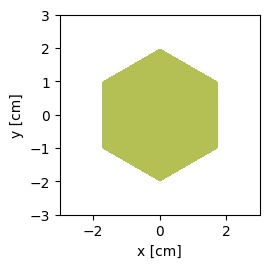

In [15]:
hex_prism = openmc.model.HexagonalPrism(2.0)
water_cell.region = -hex_prism
universe.plot(origin=(0, 0, 0), width=(6, 6))
plt.show()

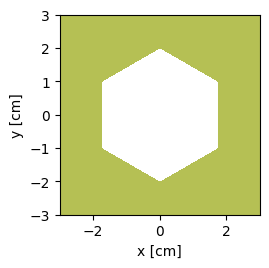

In [16]:
hex_prism = openmc.model.HexagonalPrism(2.0)
water_cell.region = +hex_prism
universe.plot(origin=(0, 0, 0), width=(6, 6))
plt.show()

Individual surfaces that make up a composite surface can be accessed on the resulting object and used in other cell definitions.

In [17]:
print(hex_prism.plane_max)

Surface
	ID                 =	10
	Name               =	
	Type               =	x-plane
	Boundary           =	transmission
	Coefficients       
x0                  =	1.7320508075688772



# Defining and Exporting a Geometry Object

A geometry object can be defined by providing a root universe. This object can write an XML `geometry.xml` to be used in an OpenMC simulation.

In [18]:
water_cell.region = -cylinder_surface
geometry = openmc.Geometry(root=universe)
geometry.export_to_xml()
!cat geometry.xml

<?xml version='1.0' encoding='UTF-8'?>
<geometry>
  <cell id="1" material="1" region="-1" universe="1"/>
  <surface coeffs="0.0 0.0 5" id="1" type="z-cylinder"/>
</geometry>
